# Validate performance of XGB models
Once the best models for each input modality have been selected (see *StageXGB*), we can assess their performance on held-out data.  
Note that this is NOT intended for model selection, but to get a sense of how these models perform while reducing biases due to overfitting.

In [2]:
import os
import numpy as np
import anndata as ad
import pandas as pd
from plotnine import *

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
import scanpy as sc
from joblib import Parallel, delayed
import warnings, logging

## Overall cell features

In [3]:
cell_table = pd.read_csv("../../data/cell_table_with_types_stage.csv", 
                         index_col = 0)

/tmp/ipykernel_197681/1000358550.py:1: DtypeWarning: Columns (39,40,41,42,43,44,45,46,48,49,52,53,54,55,56,57,58,59,60,61,62,63,65,66,68) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
metab_markers = ['CA9', 'CD98', 'CytC', 'MCT1', 'ASCT2', 'LDH', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'ARG1', 'CPT1A', 'Ki67']

# Only metabolic markers for cancer/epithelial cells
df = cell_table.loc[cell_table.consensus == "Cancer_cell",metab_markers] 
meta = cell_table.loc[cell_table.consensus == "Cancer_cell",["Stage","fov"]]

# A few FOVs show only few epithelial cells and might only add noise to the analysis
sparse_epi_fovs = meta.fov.value_counts()[meta.fov.value_counts() <= 20].index
df = df.loc[~meta.fov.isin(sparse_epi_fovs)]
meta = meta.loc[~meta.fov.isin(sparse_epi_fovs)]

# Only keep well-annotated stages
epithelial_subset = meta["Stage"].isin(["pT1", "pT2", "pT3", "pT4"]).values

## Prepare cross-validation

In [5]:
# Define which fovs will be held out for validation (outer loop)
fov_stage_table = meta.loc[epithelial_subset].drop_duplicates().reset_index(drop=True)
fov_inner, fov_val, y_inner, y_val = train_test_split(
    fov_stage_table["fov"], fov_stage_table["Stage"], test_size=0.2, random_state=0, stratify=fov_stage_table["Stage"])
meta["inner"] = meta["fov"].isin(fov_inner)
# For sanity check, the following should consistently be used as validation set
" ".join(fov_val.sort_values())

'A1a A1f A1h A2g A2i A2q A2r A3m A4e A4n A5a A5q A6b A6c A6g A6m A6p A6q A6r A7f A7p A8a A8m A9o A9q B1h B1k B2a B2b B2k B2o B3c B3g B4b B4g B4m B6i B6q B7c B7p B7r B8b B8d B8g B8i B8l B9c B9d B9h B9m B9n B9o C1i C1l C2a C2f C2k C3c C3h C4a C4g C4k C5a C5k C5l C6d C8a C8h D1i D1l D1m D2e D2k D4c D5b D5d D5h D5k D5l D6c D6k D7a D8d D8h'

In [6]:
n_splits = 4

cv_folds = StratifiedGroupKFold(n_splits=n_splits)
for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                  meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                  groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
    # All stages should be present in both train and test
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov")["Stage"].first().unique()) == 4
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov")["Stage"].first().unique()) == 4
    # Print the first test FOVs
    print(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index[:5]) 

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


In [7]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].groupby("fov").mean()
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

In [8]:
def conv_traintest_cells_to_fov():
    for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                    meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
        test_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index
        train_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov").first().index
        test_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(test_fovs))[0]
        train_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(train_fovs))[0]
        yield (train_fovs_ind, test_fovs_ind)

# Should work as the output of `split` method: two arrays of indices
cv_folds_fov = [x for x in conv_traintest_cells_to_fov()]

for train, test in cv_folds_fov:
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 4
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 4
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5])

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


In [9]:
le = LabelEncoder()
le.fit(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"])

LabelEncoder()

## Model 0: Validation baseline

In [10]:
baseline_f1 = f1_score(le.transform(meta_per_fov.loc[~meta_per_fov["inner"]]["Stage"]),
                [2 for _ in range(meta_per_fov.loc[~meta_per_fov["inner"]].shape[0])],
                average="macro")
baseline_f1

0.171875

In [11]:
np.random.seed(0)
le = LabelEncoder()
baseline_f1_scores = [f1_score(LabelEncoder().fit_transform(meta_per_fov.loc[~meta_per_fov["inner"]]["Stage"]),
                np.random.randint(0,4,meta_per_fov.loc[~meta_per_fov["inner"]].shape[0]),
                average="macro")
                for _ in range(10000)]
baseline_f1 = np.mean(baseline_f1_scores)
print(f"Baseline: {baseline_f1} (95% CI: {np.percentile(baseline_f1_scores, 2.5)}-{np.percentile(baseline_f1_scores, 97.5)})")

Baseline: 0.21745142751881236 (95% CI: 0.1372928151604622-0.3047674751179554)


In [12]:
np.random.seed(0)
le = LabelEncoder()
val_labels = meta_per_fov.loc[~meta_per_fov["inner"]]["Stage"]
baseline_f1_scores = [f1_score(le.fit_transform(val_labels),
                                le.transform(np.random.choice(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"], len(val_labels), replace=True)),
                average="macro")
                for _ in range(10000)]
baseline_f1 = np.mean(baseline_f1_scores)
print(f"Baseline: {baseline_f1} (95% CI: {np.percentile(baseline_f1_scores, 2.5)}-{np.percentile(baseline_f1_scores, 97.5)})")

Baseline: 0.2472711526984316 (95% CI: 0.16603727088216627-0.3503496160213175)


## Model 1: Cell type composition

In [13]:
cell_type_proportions = cell_table.groupby("fov")["consensus"].value_counts().unstack().fillna(0)
# Normalize by the number of cells in each FOV
cell_type_proportions = cell_type_proportions.div(cell_type_proportions.sum(axis=1), axis=0)
# Match to metadata and kept FOVs
cell_type_proportions = cell_type_proportions.loc[meta_per_fov.index]

In [19]:
best_model = pd.read_csv("../../data/model1_cell_composition_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(1)
n_estimators = best_model["estimators"].values[0]
n_depth = best_model["depth"].values[0]
best_model

,estimators,depth,score
25,15,5,0.295036


In [20]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)
with warnings.catch_warnings(action="ignore"):      
    # Step 1: Define train and validation subsets of the compositional data
    train_composition = cell_type_proportions.loc[meta_per_fov["inner"]]
    test_composition = cell_type_proportions.loc[~meta_per_fov["inner"]]
    train_meta = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
    test_meta = meta_per_fov.loc[~meta_per_fov["inner"]]["Stage"]

    # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
    xgb = XGBClassifier(
        n_estimators=n_estimators, 
        max_depth=n_depth, 
        device="cuda", 
        random_state=0)
    le = LabelEncoder()
    xgb.fit(train_composition,
            le.fit_transform(train_meta))

    # Step 3: Predict stage of each FOV in the test data
    preds = xgb.predict(test_composition)

    # Step 4: Compute f1_score
    score = f1_score(le.fit_transform(test_meta), 
                    preds, 
                    average="macro")
    print(score)
    
    confmat = confusion_matrix(le.transform(test_meta), preds)
    print(confmat)


0.24710648148148148
[[ 0  0  4  0]
 [ 0  1 14  2]
 [ 0  6 32  6]
 [ 0  0 14  5]]


In [21]:
# Display confusion matrix
confmat = pd.DataFrame(confmat, 
                       columns=le.classes_, 
                       index=le.classes_)
# Convert to long format for ggplot
confmat = confmat.stack().reset_index()
confmat.columns = ["True label", "Predicted label", "Count"]

In [22]:
# Table used to score inner fold scores for all models
all_models_val = pd.DataFrame(columns=["model", "score"])
# Add the model
current_model = "M1 composition"
all_models_val = pd.concat([all_models_val, 
                            pd.DataFrame({
                                "model": [current_model],
                                "score": [score]
                            })], ignore_index=True)

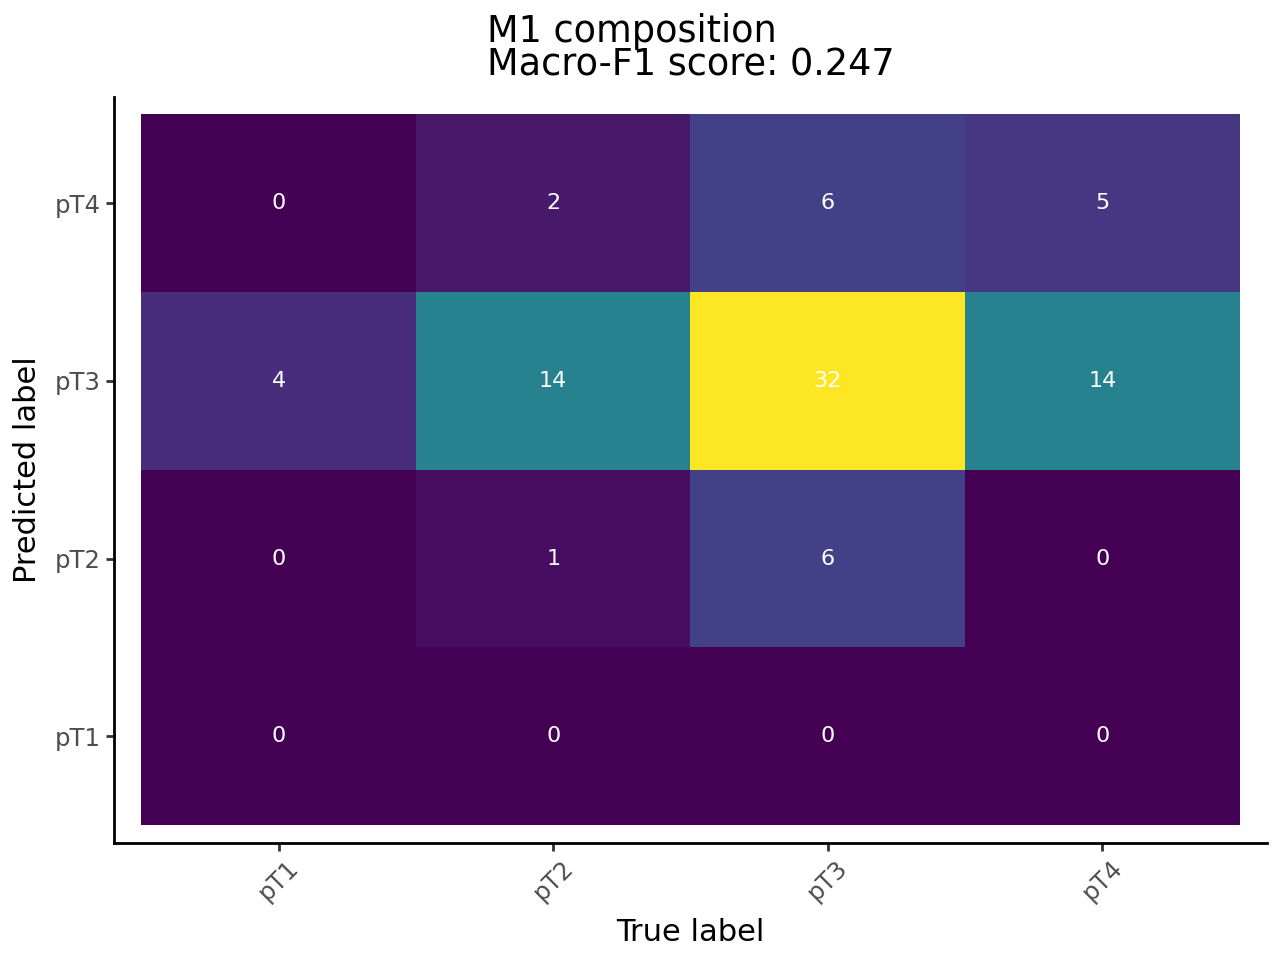

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig2/confmat_stage_proportion.pdf


In [23]:
gp = (ggplot(confmat, aes(x="True label", y="Predicted label", fill="Count")) +
      geom_tile() +
      geom_text(aes(label="Count"), color = "#ffffff", size=8) +
      theme_classic() +
      theme(legend_position="none", axis_text_x=element_text(angle=45)) +
      labs(title=f"{current_model}\nMacro-F1 score: {score:.3f}"))
gp.show()
ggsave(gp, "../../figures/fig2/confmat_stage_proportion.pdf", dpi = 300, height = 3.5, width = 3.5)

## Model 2: Metabolic intensities
See *MetabViz.ipynb* for details.

In [35]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].groupby("fov")
df_per_fov = df_per_fov.mean().join(df_per_fov.std(), rsuffix="_std")
assert meta_per_fov.index.equals(df_per_fov.index)

In [36]:
best_model = pd.read_csv("../../data/model2_metab_markers_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(1)
n_estimators, n_depth = best_model.iloc[0,:2]
best_model

,estimators,depth,score
0,15,3,0.287336


In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)
with warnings.catch_warnings(action="ignore"):      
    # Step 1: Define train and test subsets of the compositional data
    train_metab = df_per_fov.loc[meta_per_fov["inner"]]
    test_metab = df_per_fov.loc[~meta_per_fov["inner"]]
    train_meta = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
    test_meta = meta_per_fov.loc[~meta_per_fov["inner"]]["Stage"]

    # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
    xgb = XGBClassifier(
        n_estimators=int(n_estimators), 
        max_depth=int(n_depth), 
        device="cuda", 
        random_state=0)
    xgb.fit(train_metab,
            le.transform(train_meta))

    # Step 3: Predict stage of each FOV in the test data
    preds = xgb.predict(test_metab)

    # Step 4: Compute f1_score
    score = f1_score(le.transform(test_meta), 
                    preds, 
                    average="macro")
    print(score)

    confmat = confusion_matrix(le.transform(test_meta), preds)
    print(confmat)

0.2933339808339808
[[ 0  2  2  0]
 [ 0  4 10  3]
 [ 0  4 33  7]
 [ 0  0 15  4]]


In [38]:
# Display confusion matrix
confmat = pd.DataFrame(confmat, 
                       columns=le.classes_, 
                       index=le.classes_)
# Convert to long format for ggplot
confmat = confmat.stack().reset_index()
confmat.columns = ["True label", "Predicted label", "Count"]

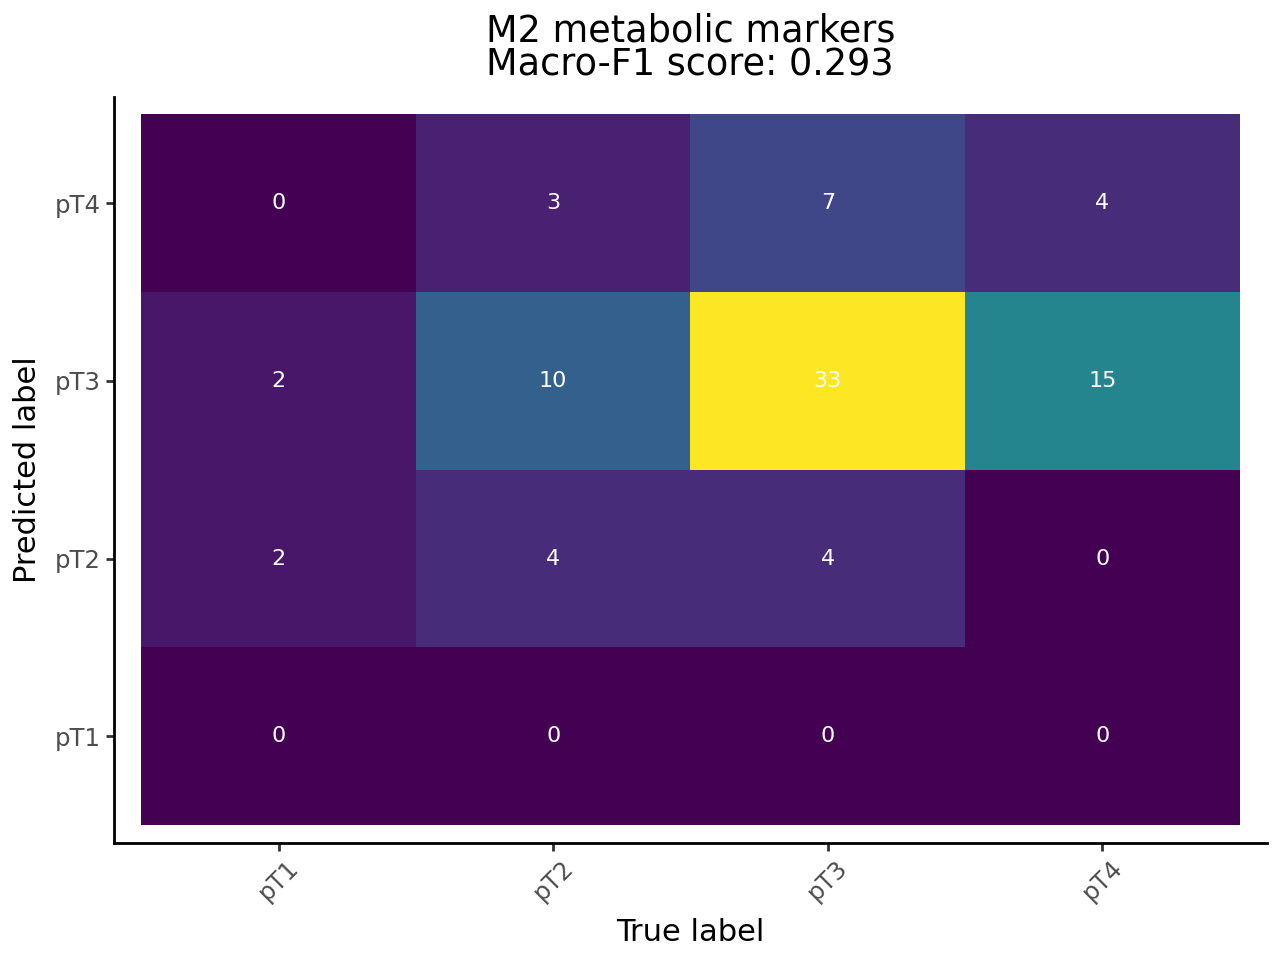

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/confmat_stage_metab_markers.pdf


In [39]:
# Add the model
current_model = "M2 metabolic markers"
all_models_val = pd.concat([all_models_val, 
                            pd.DataFrame({
                                "model": [current_model],
                                "score": [score]
                            })], ignore_index=True)
gp = (ggplot(confmat, aes(x="True label", y="Predicted label", fill="Count")) +
      geom_tile() +
      geom_text(aes(label="Count"), color = "#ffffff", size=8) +
      theme_classic() +
      theme(legend_position="none", axis_text_x=element_text(angle=45)) +
      labs(title=f"{current_model}\nMacro-F1 score: {score:.3f}"))
gp.show()
ggsave(gp, "../../figures/fig3/confmat_stage_metab_markers.pdf", dpi = 300, height = 3.5, width = 3.5)

## Model 3: Functional features

In [40]:
func_features = ["STING1", "Ki67", "MSH2", "MSH6", "PDL1"]

# We start by looking at the cell shape of cancer cells
df_func = cell_table.loc[cell_table.consensus == "Cancer_cell",func_features] 
# df_morpho.index = df_morpho.index.astype(str)
df_func = df_func.loc[meta.index].loc[epithelial_subset]
df_func["fov"] = meta.loc[epithelial_subset]["fov"]
# For mean and std
df_func_per_fov = df_func.groupby("fov").mean().join(df_func.groupby("fov").std(), rsuffix="_std")

assert meta_per_fov.index.equals(df_func_per_fov.index)

In [57]:
best_model = pd.read_csv("../../data/model6_functional_markers_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(1)
n_estimators, n_depth = best_model.iloc[0,:2]

In [58]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)
with warnings.catch_warnings(action="ignore"):      
    # Step 1: Define train and test subsets of the compositional data
    train_func = df_func_per_fov.loc[meta_per_fov["inner"]]
    test_func = df_func_per_fov.loc[~meta_per_fov["inner"]]
    train_meta = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
    test_meta = meta_per_fov.loc[~meta_per_fov["inner"]]["Stage"]

    # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
    xgb = XGBClassifier(
        n_estimators=int(n_estimators), 
        max_depth=int(n_depth), 
        device="cuda", 
        random_state=0)
    xgb.fit(train_func,
            le.transform(train_meta))

    # Step 3: Predict stage of each FOV in the test data
    preds = xgb.predict(test_func)

    # Step 4: Compute f1_score
    score = f1_score(le.transform(test_meta), 
                    preds, 
                    average="macro")
    print(score)

    confmat = confusion_matrix(le.transform(test_meta), preds)
    print(confmat)

0.27343166005405095
[[ 0  1  3  0]
 [ 0  5 11  1]
 [ 0  6 30  8]
 [ 0  5 11  3]]


In [59]:
# Display confusion matrix
confmat = pd.DataFrame(confmat, 
                       columns=le.classes_, 
                       index=le.classes_)
# Convert to long format for ggplot
confmat = confmat.stack().reset_index()
confmat.columns = ["True label", "Predicted label", "Count"]

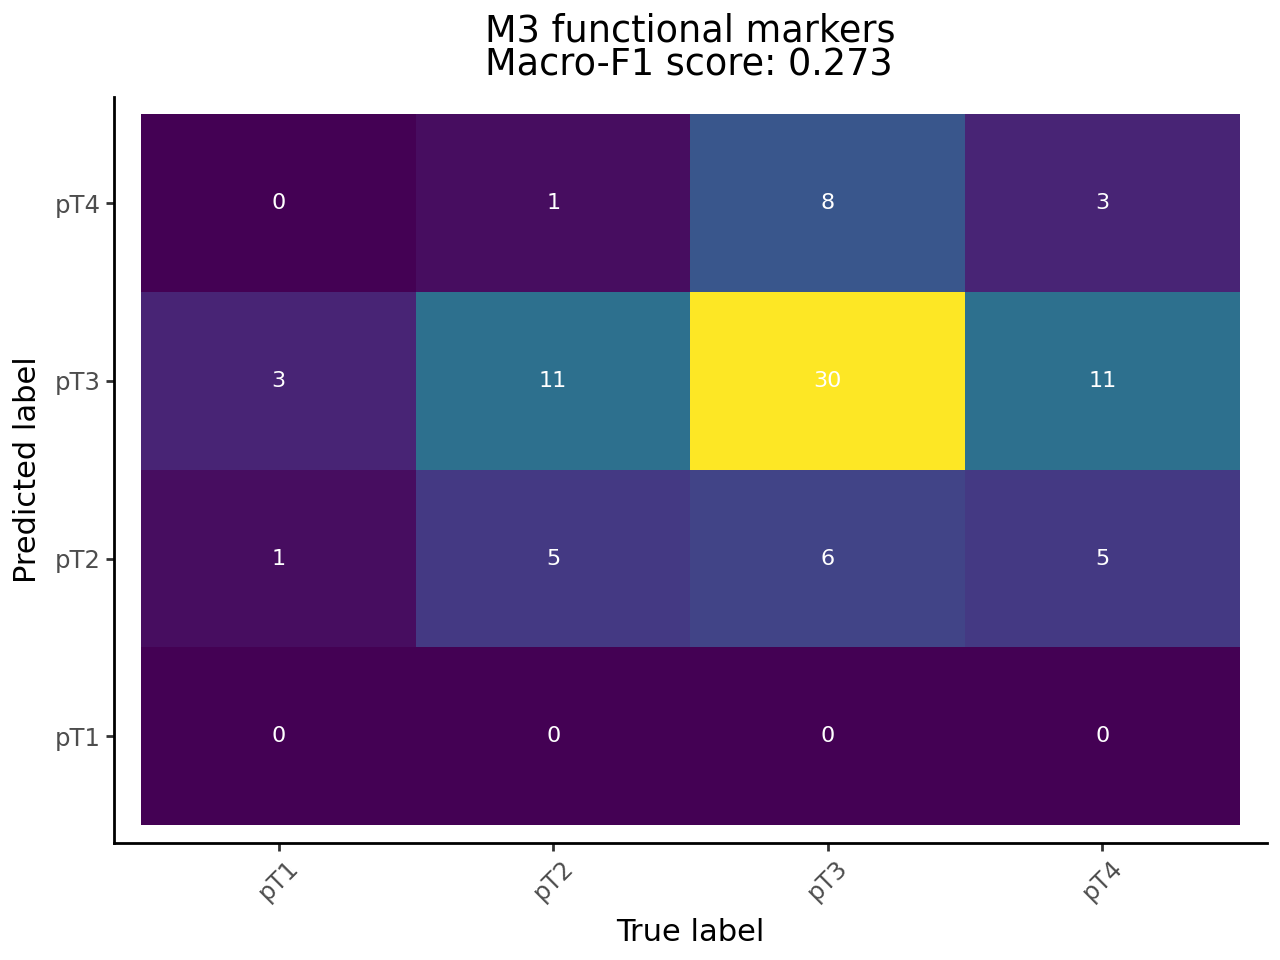

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/confmat_stage_functional_markers.pdf


In [ ]:
# Add the model
current_model = "M3 functional markers"
all_models_val = pd.concat([all_models_val, 
                            pd.DataFrame({
                                "model": [current_model],
                                "score": [score]
                            })], ignore_index=True)
gp = (ggplot(confmat, aes(x="True label", y="Predicted label", fill="Count")) +
      geom_tile() +
      geom_text(aes(label="Count"), color = "#ffffff", size=8) +
      theme_classic() +
      theme(legend_position="none", axis_text_x=element_text(angle=45)) +
      labs(title=f"{current_model}\nMacro-F1 score: {score:.3f}"))
gp.show()
ggsave(gp, "../../figures/fig4/confmat_stage_functional_markers.pdf", dpi = 300, height = 3.5, width = 3.5)

## Model 4: Morphological features

In [45]:
morpho_features = ['eccentricity', 'perimeter', 'area']

# We start by looking at the cell shape of cancer cells
df_morpho = cell_table.loc[cell_table.consensus == "Cancer_cell",morpho_features] 
# df_morpho.index = df_morpho.index.astype(str)
df_morpho = df_morpho.loc[meta.index].loc[epithelial_subset]
df_morpho["fov"] = meta.loc[epithelial_subset]["fov"]
# For mean and std
df_morpho_per_fov = df_morpho.groupby("fov").mean().join(df_morpho.groupby("fov").std(), rsuffix="_std")

assert meta_per_fov.index.equals(df_morpho_per_fov.index)

In [47]:
best_model = pd.read_csv("../../data/model5_cell_morphology_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(1)
n_estimators, n_depth = best_model.iloc[0,:2]

In [48]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)
with warnings.catch_warnings(action="ignore"):      
    # Step 1: Define train and test subsets of the compositional data
    train_morphology = df_morpho_per_fov.loc[meta_per_fov["inner"]]
    test_morphology = df_morpho_per_fov.loc[~meta_per_fov["inner"]]
    train_meta = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
    test_meta = meta_per_fov.loc[~meta_per_fov["inner"]]["Stage"]

    # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
    xgb = XGBClassifier(
        n_estimators=int(n_estimators), 
        max_depth=int(n_depth), 
        device="cuda", 
        random_state=0)
    le = LabelEncoder()
    xgb.fit(train_morphology,
            le.fit_transform(train_meta))

    # Step 3: Predict stage of each FOV in the test data
    preds = xgb.predict(test_morphology)

    # Step 4: Compute f1_score
    score = f1_score(le.transform(test_meta), 
                    preds, 
                    average="macro")
    print(score)

    confmat = confusion_matrix(le.transform(test_meta), preds)
    print(confmat)

0.25721062618595825
[[ 0  0  4  0]
 [ 0  3 12  2]
 [ 1  9 29  5]
 [ 0  2 13  4]]


In [49]:
# Display confusion matrix
confmat = pd.DataFrame(confmat, 
                       columns=le.classes_, 
                       index=le.classes_)
# Convert to long format for ggplot
confmat = confmat.stack().reset_index()
confmat.columns = ["True label", "Predicted label", "Count"]

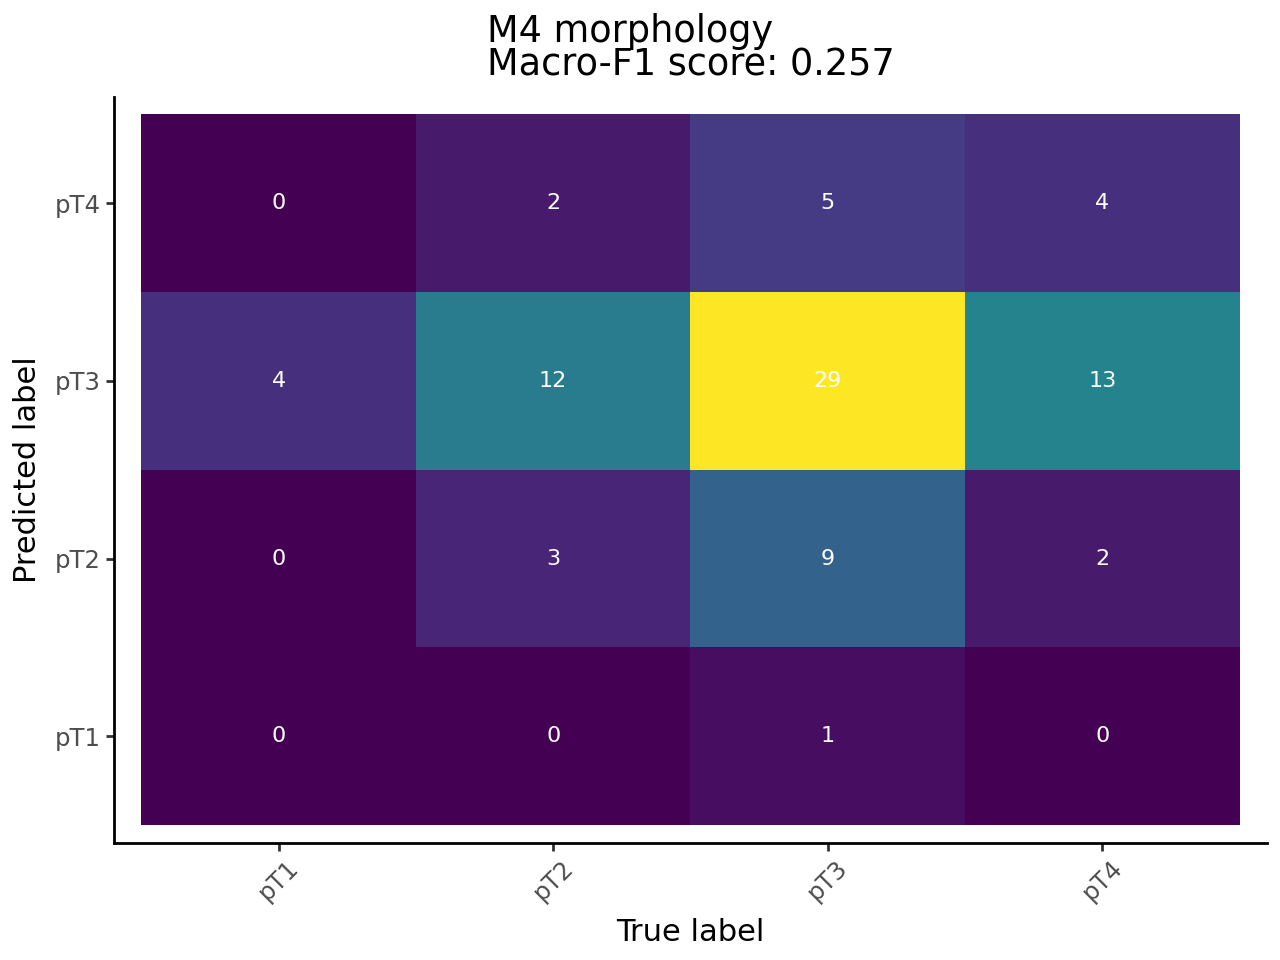

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/confmat_stage_morphology.pdf


In [50]:
# Add the model
current_model = "M4 morphology"
all_models_val = pd.concat([all_models_val, 
                            pd.DataFrame({
                                "model": [current_model],
                                "score": [score]
                            })], ignore_index=True)
gp = (ggplot(confmat, aes(x="True label", y="Predicted label", fill="Count")) +
      geom_tile() +
      geom_text(aes(label="Count"), color = "#ffffff", size=8) +
      theme_classic() +
      theme(legend_position="none", axis_text_x=element_text(angle=45)) +
      labs(title=f"{current_model}\nMacro-F1 score: {score:.3f}"))
gp.show()
ggsave(gp, "../../figures/fig4/confmat_stage_morphology.pdf", dpi = 300, height = 3.5, width = 3.5)

## Model 5: MISTy cell type features
See *MistyLines.ipynb*.

In [61]:
misty_features_raw = pd.read_csv("../../data/misty_lineage_features.csv", index_col=0)
# Subset to top 100 most common features
misty_features = misty_features_raw.iloc[:,np.argsort(-np.sum(misty_features_raw > 0))[:100]]
# FOVs now exclude healthy samples
misty_features = misty_features.loc[meta_per_fov.index]

In [62]:
best_model = pd.read_csv("../../data/model3_misty_lineage_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(1)
n_estimators, n_depth = best_model.iloc[0,:2]
best_model

,estimators,depth,score
81,45,7,0.423738


In [63]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)
with warnings.catch_warnings(action="ignore"):
    # Step 1: Define train and test subsets of the MISTy data
    train_misty = misty_features.loc[meta_per_fov["inner"]]
    test_misty = misty_features.loc[~meta_per_fov["inner"]]
    train_meta = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
    test_meta = meta_per_fov.loc[~meta_per_fov["inner"]]["Stage"]
    
    # Step 2: Train a classifier on the training data to predict the stage of each FOV
    xgb = XGBClassifier(
        n_estimators=int(n_estimators), 
        max_depth=int(n_depth), 
        device="cuda", 
        random_state=0)
    le = LabelEncoder()
    xgb.fit(train_misty,
            le.fit_transform(train_meta))
    
    # # Step 3: Predict stage of each FOV in the test data
    preds = xgb.predict(test_misty)

    # # Step 4: Compute f1_score
    score = f1_score(le.transform(test_meta), 
                    preds, 
                    average="macro")
    print(score)
    
    confmat = confusion_matrix(le.transform(test_meta), preds)
    print(confmat)

0.33307692307692305
[[ 0  2  1  1]
 [ 0  3 11  3]
 [ 0  3 36  5]
 [ 0  0 12  7]]


In [64]:
# Display confusion matrix
confmat = pd.DataFrame(confmat, 
                       columns=le.classes_, 
                       index=le.classes_)
# Convert to long format for ggplot
confmat = confmat.stack().reset_index()
confmat.columns = ["True label", "Predicted label", "Count"]

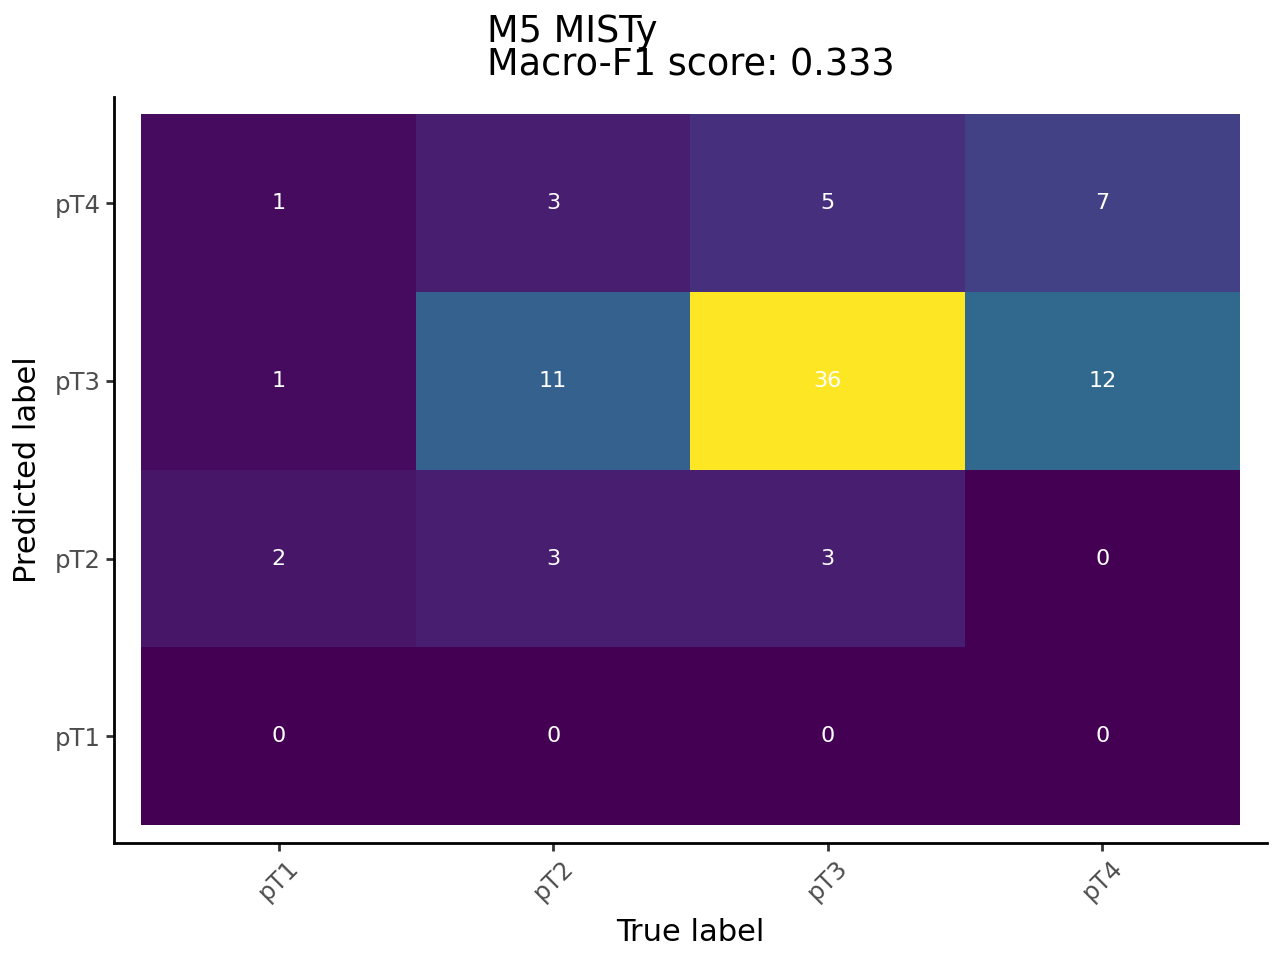

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/confmat_stage_misty.pdf


In [65]:
# Add the model
current_model = "M5 MISTy"
all_models_val = pd.concat([all_models_val, 
                            pd.DataFrame({
                                "model": [current_model],
                                "score": [score]
                            })], ignore_index=True)
gp = (ggplot(confmat, aes(x="True label", y="Predicted label", fill="Count")) +
      geom_tile() +
      geom_text(aes(label="Count"), color = "#ffffff", size=8) +
      theme_classic() +
      theme(legend_position="none", axis_text_x=element_text(angle=45)) +
      labs(title=f"{current_model}\nMacro-F1 score: {score:.3f}"))
gp.show()
ggsave(gp, "../../figures/fig4/confmat_stage_misty.pdf", dpi = 300, height = 3.5, width = 3.5)

## Model 6: Kasumi metabolic features
See *KasumiColorectal.ipynb*.

In [68]:
# Folder where the cluster proportions are stored
kasumi_folder = "kasumi_colorectal_metab_256_clusters/"
kasumi_files = os.listdir(kasumi_folder)

In [69]:
best_model = pd.read_csv("../../data/model4_kasumi_markers_f1_scores.txt", header=None, 
            names=["estimators", "cuts", "res", "depth", "score"]).sort_values("score", ascending=False).head(1)
n_estimators, cuts, res, n_depth = best_model.values[0,:4]
n_estimators = int(n_estimators)

In [70]:
kasumi_run = pd.read_csv(f"{kasumi_folder}cuts_{cuts}_res_{res}.csv", index_col=0)
# Subset to cancer samples
kasumi_run = kasumi_run.loc[meta_per_fov.index]

In [71]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)
with warnings.catch_warnings(action="ignore"):
    # Step 1: Define train and test subsets of the MISTy data
    train_kasumi = kasumi_run.loc[meta_per_fov["inner"]]
    test_kasumi = kasumi_run.loc[~meta_per_fov["inner"]]
    train_meta = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
    test_meta = meta_per_fov.loc[~meta_per_fov["inner"]]["Stage"]
    
    # Step 2: Train a classifier on the training data to predict the stage of each FOV
    xgb = XGBClassifier(
        n_estimators=int(n_estimators), 
        max_depth=int(n_depth), 
        device="cuda", 
        random_state=0)
    le = LabelEncoder()
    xgb.fit(train_kasumi,
            le.fit_transform(train_meta))
    
    # # Step 3: Predict stage of each FOV in the test data
    preds = xgb.predict(test_kasumi)

    # # Step 4: Compute f1_score
    score = f1_score(le.transform(test_meta), 
                    preds, 
                    average="macro")
    print(score)
    
    confmat = confusion_matrix(le.transform(test_meta), preds)
    print(confmat)

0.2569125909551442
[[ 0  0  3  1]
 [ 1  5  7  4]
 [ 1  9 26  8]
 [ 0  2 14  3]]


In [72]:
# Display confusion matrix
confmat = pd.DataFrame(confmat, 
                       columns=le.classes_, 
                       index=le.classes_)
# Convert to long format for ggplot
confmat = confmat.stack().reset_index()
confmat.columns = ["True label", "Predicted label", "Count"]

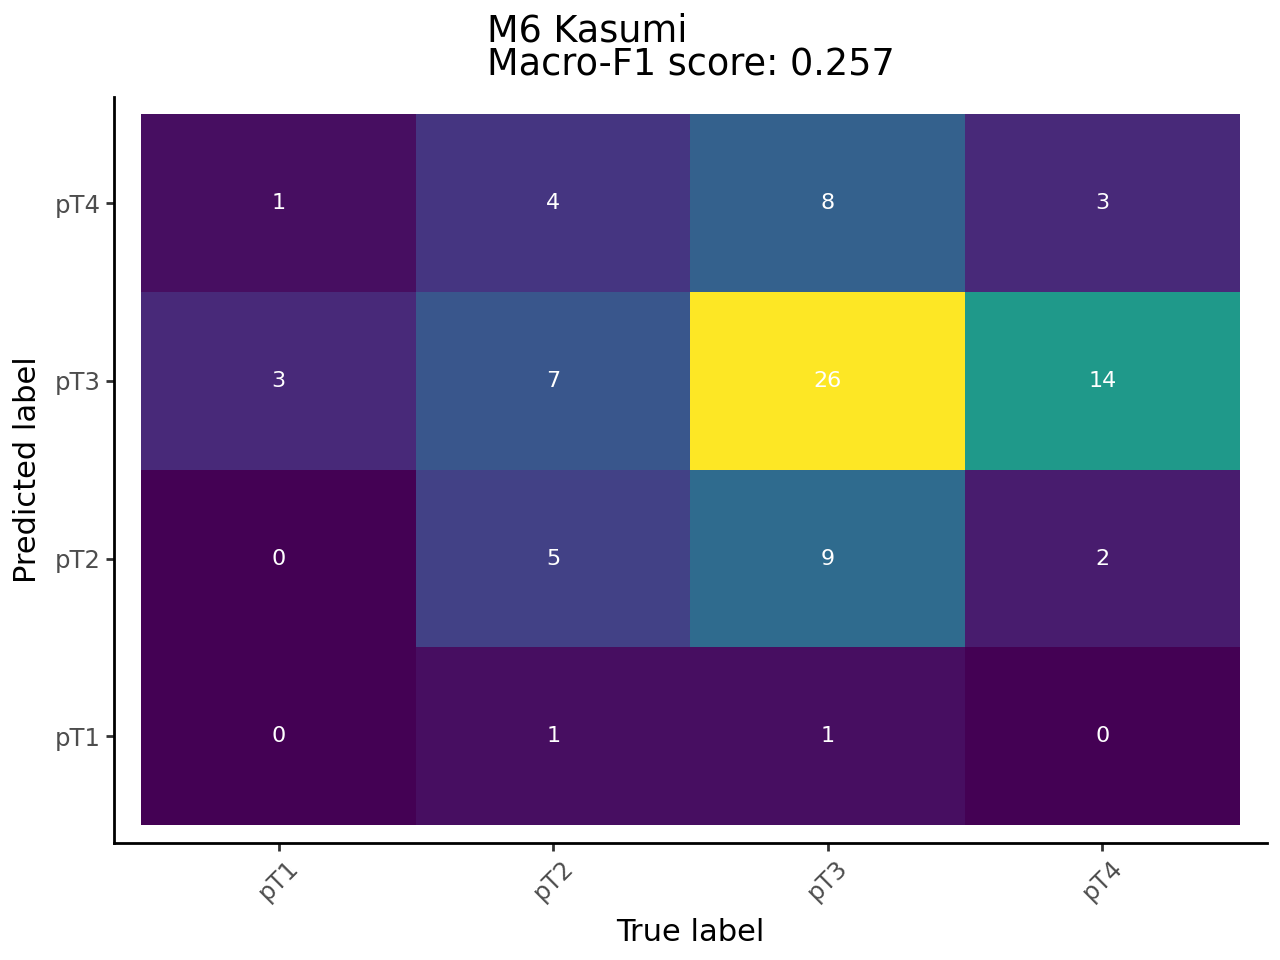

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/confmat_stage_kasumi.pdf


In [73]:
# Add the model
current_model = "M6 Kasumi"
all_models_val = pd.concat([all_models_val, 
                            pd.DataFrame({
                                "model": [current_model],
                                "score": [score]
                            })], ignore_index=True)
gp = (ggplot(confmat, aes(x="True label", y="Predicted label", fill="Count")) +
      geom_tile() +
      geom_text(aes(label="Count"), color = "#ffffff", size=8) +
      theme_classic() +
      theme(legend_position="none", axis_text_x=element_text(angle=45)) +
      labs(title=f"{current_model}\nMacro-F1 score: {score:.3f}"))
gp.show()
ggsave(gp, "../../figures/fig4/confmat_stage_kasumi.pdf", dpi = 300, height = 3.5, width = 3.5)

## Summary of model validation

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 11.2 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/validation_f1_scores.pdf


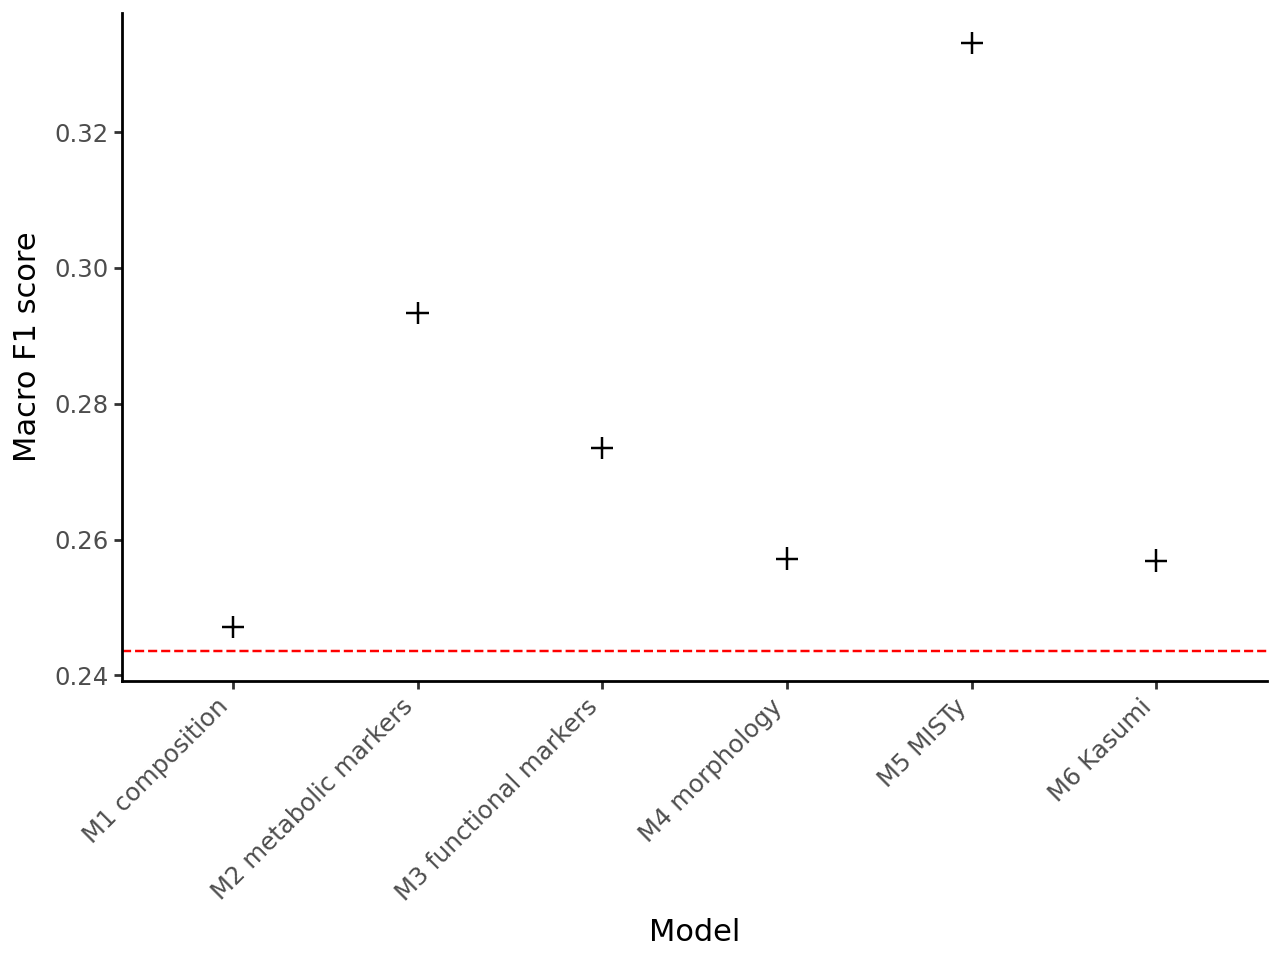

In [74]:
gp = (ggplot(all_models_val, aes(x = "model", y = "score")) 
      + geom_point(shape = '+', size = 4)
      + theme_classic()
      + geom_hline(yintercept=np.median(baseline_f1_scores), linetype="dashed", color="red")
      + theme(axis_text_x = element_text(angle = 45, hjust = 1))
      + labs(x = "Model", y = "Macro F1 score")
)
ggsave(gp, "../../figures/fig4/validation_f1_scores.pdf", width=11.2, height=5)
gp.show()